Ce notebook peut être exécuté en ligne avec le binder : 
 [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/fchatelain/ExemplesFLO/master?urlpath=lab/tree/3_Wiener_discret-modeles_AR%2FN3_analyse_voyelle.ipynb)

# Analyse et synthèse de sons

0. Chargement et visualisation du signal de parole
1. Analyse : modèle AR pour un signal de parole. On estime les coefficients et la puissance du bruit (Eq. Yule Walker). 
2. Synthèse : On génère un signal d'excitation (en s'inpirant de celui estimé sur le signal de départ) dont on se sert pour exciter un filtre AR (coeff estimé sur un son).

Exemple sur des sons voisés (voyelles)

In [1]:
import numpy as np
import pylab
import spectrum
import scipy.signal
from matplotlib import pyplot as plt
from scipy.io import wavfile

from pathlib import Path

# afficher des figures dans le notebook
# utiliser 'widget' au lieu de 'inline' pour un affichage interactif
%matplotlib inline

## 0. Chargement et visualisation du signal de parole

On charge le signal sonore : une voyelle (`'a','e','i','o','u'`) prononcée par un homme

In [2]:
Fe = 8000  # Hz
N = 240  # fenetre de 30ms
P = 30  # ordre modele AR

## File reading
voyelle = "o"  # on peut tester également les autres 'e','i','o','u' !

basename = Path("data")  # comptabilité windows/mac/linux
filename = "voy" + voyelle + ".wav"
fs, data = wavfile.read(basename / filename)
signal_voice = np.array(data, dtype=float)
Nbre_ech = len(signal_voice)
print("Frequence d'échantillonnage Fe={}Hz".format(fs))

vmax_signal_voice = np.max(np.abs(signal_voice))
time = np.arange(Nbre_ech) / fs  # (s)
indplot = np.arange(500, 1500)

Frequence d'échantillonnage Fe=8000Hz


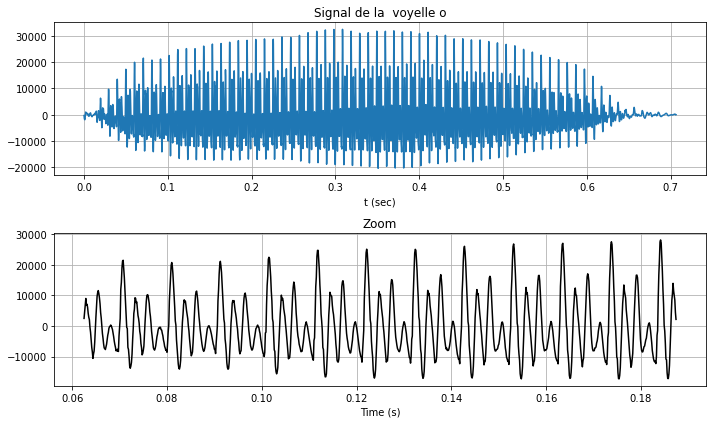

In [3]:
# Visualization
f, axes = plt.subplots(2, 1, figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(time, signal_voice)
plt.title("Signal de la  voyelle {}".format(voyelle))
plt.xlabel("t (sec)")
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(time[indplot], signal_voice[indplot], "k-")
plt.title("Zoom")
plt.xlabel("Time (s)")
plt.tight_layout()

Sur les graphes ci dessus, on peut remarquer que pour des sons dits *voisés* (i.e. comme les voyelles), le signal est très *harmonique* ou quasi-périodique

In [4]:
# Play voice signal
from IPython.display import Audio

Audio(signal_voice / np.max(np.abs(signal_voice)), rate=fs)

## 1. **Analyse**: calcul des coefficients du modèle AR

Résolution des équations de Yule-Walker, qui est l'équivalent des équations de Wiener-Hopf discrètes pour la prédiction linéaire à 1 pas (modèle AR)

In [5]:
# Reject the initial and final transients
y = signal_voice[500 : int(np.fix(Nbre_ech * 0.8))]
# Estimation of AR values using Yule-Walker method:
#  we use here the biased estimate of the correlation function (default choice)
a, sigma2, _ = spectrum.aryule(y, P, norm="biased")

Filtrage inverse : Calcul du signal d'excitation (glottique)

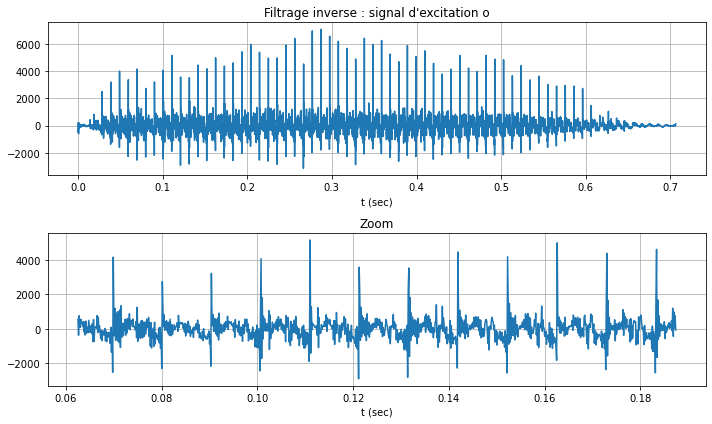

In [6]:
# signal d'excitation glottique
coeffs = np.append(1, a)
excitation = scipy.signal.lfilter(coeffs, 1, signal_voice)

f, axes = plt.subplots(2, 1, figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(time, excitation)
plt.title("Filtrage inverse : signal d'excitation {}".format(voyelle))
plt.xlabel("t (sec)")
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(time[indplot], excitation[indplot])
plt.title("Zoom")
plt.xlabel("t (sec)")
plt.tight_layout()

Sur les graphes ci dessus, que peut-on dire de la forme du signal d'excitation : est-ce un bruit blanc ou plutôt un train d'impulsions périodiques ?

Pour des sons voisés,  on remarque effectivement que pour une modélisation AR le signal d'excitation ressemble à un train d'impulsion périodique. Cela s'explique physiquement par les fermetures/ouvertures périodiques de la glotte lors de la production des sons voisés par l'appareil vocal.

Cete fréquence s'appelle le *pitch*. ou encore la hauteur de la voix parlée. Elle est autour de $100$Hz pour un homme, $200$Hz pour une femme et jusqu'à $400$Hz pour des enfants.

On peut facilement estimer ce pitch, ou son inverse en regardant la valeur du retard obtenu pour le **second** maximum de la fonction d'autocorrélation (*rappel* : la fonction d'autocorrélation d'un signal périodique est une fonction périodique de même période)

In [7]:
## Computing the pitch
pitch_min = 20  #  2.5ms (basic frequency at 400 Hz)
pitch_max = pitch_min + 100  # 15ms (basic frequency at 66 Hz)
## Useful function to compute the pitch
def calcul_du_pitch(signal, pitch_min=20, pitch_max=120):
    # pitch_min == 20 is 2.5ms range at fe=8kHz (basic frequency at 400 Hz)
    #  pitch_max == 120 is 15ms (basic frequency at 66 Hz)
    nlags = pitch_max - pitch_min + 1
    autocorr_norm = np.zeros((nlags))
    signal = signal.flatten()

    for k in range(nlags):
        x = signal[: -pitch_min - k]
        xret = signal[pitch_min + k :]
        autocorr_norm[k] = np.sum(x * xret) / np.sqrt(
            np.sum(x ** 2) * np.sum(xret ** 2)
        )

    ipitch = np.argmax(autocorr_norm)
    val = autocorr_norm[ipitch]
    pitch = ipitch + pitch_min

    voise = 1
    if (pitch == pitch_min) or val < 0.8:
        voise = 0
        pitch = pitch_min
    return pitch, voise


pitch, voise = calcul_du_pitch(signal_voice, pitch_min, pitch_max)

if voise:
    print("Pitch estime : {:.2f} (Hz)".format(Fe / pitch))

Pitch estime : 97.56 (Hz)


**A tester** : faites varier la fréquence du pitch utilisé pour la synthèse et écoutez l'effet sur le son obtenu

In [8]:
# Modification à la main du pitch: Attention il s'agit ici de la période (inverse de la fréquence) exprimée en nbre d'échantillons
freq_pitch = 200  # Hz
pitch = int(Fe / freq_pitch)

## 2. Synthèse du son voisé à l'aide du modèle AR

In [9]:
# transitoire pour attaque et fin progressive
Nsynth_stat = 8000
Nsynth_trans_B = 240
Nsynth_trans_E = 480

factSigma_B = np.exp(np.log(0.05) / Nsynth_trans_B)
factSigma_E = np.exp(np.log(0.001) / Nsynth_trans_E)

Nsynth = Nsynth_stat + Nsynth_trans_B + Nsynth_trans_E
indice = Nsynth_stat + Nsynth_trans_B + Nsynth_trans_E


# voise = 0

# Choix binaire du signal d'excitation :
# train d'impulsion si voise, bruit blanc sinon
if voise == 1:
    excitation_synth = np.zeros((Nsynth))
    # Train d'impulsions
    indice = indice - Nsynth - 1
    if indice < 1:
        indice = 1 - pitch
    amplitude_stat = np.sqrt(pitch * sigma2)
    while indice + pitch <= Nsynth:
        indice = indice + pitch
        # To account for the initial and final transient
        if indice < Nsynth_trans_B:
            amplitude = np.sqrt(pitch * sigma2 * 0.05 / (factSigma_B ** indice))
        elif Nsynth - indice < Nsynth_trans_E:
            time_residual = Nsynth_trans_E - Nsynth + indice
            amplitude = np.sqrt(pitch * sigma2 * (factSigma_E ** (time_residual)))
        else:
            amplitude = amplitude_stat
        excitation_synth[indice] = amplitude
else:
    # Bruit Blanc
    excitation_synth = np.sqrt(sigma2) * np.random.normal(size=(Nsynth,))

#  Filtrage AR du signal d'excitation
b = np.zeros((coeffs.shape[0]))
b[0] = 1
signal_synth = scipy.signal.lfilter(b, coeffs, excitation_synth)

**A tester** : dans le code de synthèse ci-dessus, modifier le flag `voise` pour produire un son non-voisé. Que constatez vous alors (cf cellules ci dessous) à l'écoute ?

### Visualisation et écoute du signal synthétique et de parole

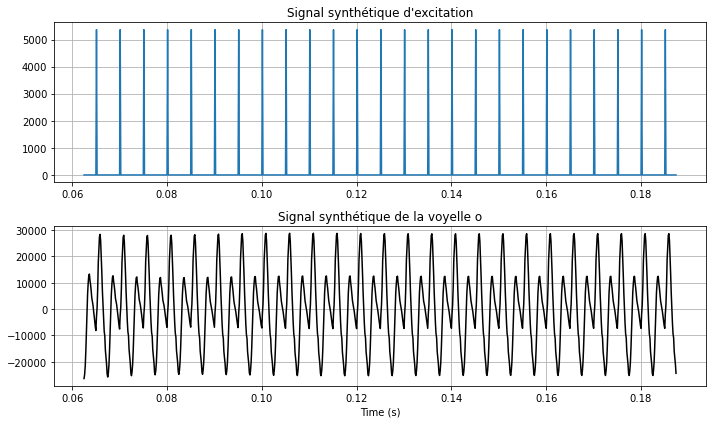

In [10]:
# Visualization of synthetic signals
f, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(time[indplot], excitation_synth[indplot])
plt.title("Signal synthétique d'excitation")
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(time[indplot], signal_synth[indplot], "k-")
plt.title("Signal synthétique de la voyelle {}".format(voyelle))
plt.xlabel("Time (s)")
plt.tight_layout()

In [11]:
# Play synthetic signal
from IPython.display import Audio

Audio(signal_synth / np.max(np.abs(signal_synth)), rate=fs)

In [12]:
# Play voice signal to compare
from IPython.display import Audio

Audio(signal_voice / np.max(np.abs(signal_voice)), rate=fs)

### Calcul et visualisation des DSP du signal synthétique et de parole

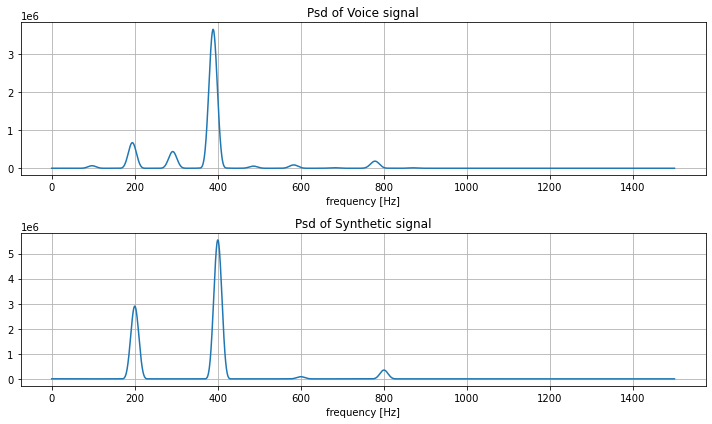

In [13]:
from scipy import signal

nwin = 512
noverlap = 8

sigvoice_len = len(signal_voice)
istart = int(sigvoice_len / 4)
iend = int(3 * sigvoice_len / 4)

sigv = signal_voice[istart:iend]
nref = signal_voice.size
fvoice, Pvoice_den = signal.welch(
    sigv,
    fs,
    window=signal.get_window("hanning", nwin),
    noverlap=noverlap,
    nfft=2 * sigvoice_len,
)
ivoice = np.where(fvoice < 1500)[0]

sigsynth_len = len(signal_synth)
istart = int(sigsynth_len / 4)
iend = int(3 * sigsynth_len / 4)

sigs = signal_synth[istart:iend]
nref = signal_synth.size
fsynth, Psynth_den = signal.welch(
    sigs,
    fs,
    window=signal.get_window("hanning", nwin),
    noverlap=noverlap,
    nfft=2 * sigsynth_len,
)
isynth = np.where(fsynth < 1500)[0]

plt.subplots(figsize=(10, 6), sharex=True)
plt.subplot(2, 1, 1)
plt.grid()
# plt.yscale('log')
plt.plot(fvoice[ivoice], Pvoice_den[ivoice])
plt.xlabel("frequency [Hz]")
plt.title("Psd of Voice signal")
plt.figure(num=1, figsize=(18, 7))
plt.subplot(2, 1, 2)
plt.grid()
# plt.yscale('log')
plt.plot(fsynth[isynth], Psynth_den[isynth])
plt.xlabel("frequency [Hz]")
plt.title("Psd of Synthetic signal")
plt.tight_layout()

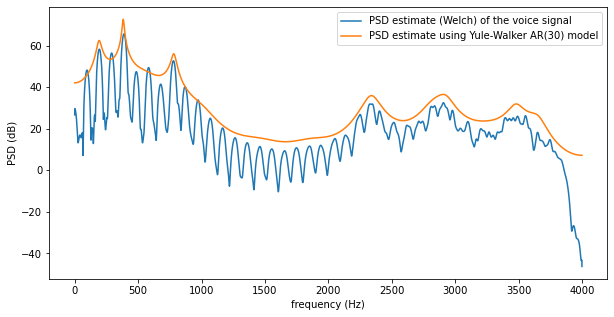

In [14]:
plt.figure(figsize=(10, 5))
# Magnitude (dB) for the Welch PSD estimate of the voice
plt.plot(
    fvoice, 10 * np.log10(Pvoice_den), label="PSD estimate (Welch) of the voice signal"
)
# Magnitude (dB) for the PSD estimate of the AR model
psd_ar = spectrum.arma2psd(A=a, rho=np.sqrt(sigma2))
psd_ar = psd_ar[len(psd_ar) : len(psd_ar) // 2 : -1]
plt.plot(
    np.linspace(0, 0.5 * fs, len(psd_ar)),
    10 * np.log10(abs(psd_ar)),
    label="PSD estimate using Yule-Walker AR({}) model".format(P),
)
plt.xlabel(r"frequency (Hz)")
plt.ylabel("PSD (dB)")
plt.legend();

**Question**:
- le spectre du modèle AR est-il cohérent avec celui du signal de parole et le signal de parole ?
- A quoi correspondent les oscillations rapides dans le spectre (en dB) du signal de parole pour ce son voisé ?